In [1]:
"""Libraries"""
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
from copy import copy, deepcopy
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector, SelectPercentile, mutual_info_regression, VarianceThreshold
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, BayesianRidge, Lasso
from bias_correction import BiasCorrection, XBiasCorrection
from IPython.core.interactiveshell import InteractiveShell
from sklearn.kernel_ridge import KernelRidge
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

"""Notebook Settings"""
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

"""Variables"""
variables = ["tmean", "tmax", "tmin", "rain"]
temp_variables = ["tmean", "tmax", "tmin"]
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(4,11))
homogeneous_groups = list(range(1,5))
group_to_relative_production = {1:0.37, 2:0.23, 3:0.23, 4:0.18}
vars_group1 = ['Tmax_Aug', 'Ltemp_July', 'Ltemp_Oct', 'Tmean_Oct', 'Rain_Sep', 'Hrainfall_Aug', 'Hrainfall_July',
               'Tmin_Sep', 'Ltemp_May', 'Tmean_June', 'Hrainfall_May', 'Tmin_Aug', 'Htemp_Oct', 'Ltemp_June', 'Rainy_days_Sep']
vars_group2 = ['Drought_Sep', 'Ltemp_July', 'Rainy_days_June', 'Rain_Oct', 'Drought_May', 'Drought_Oct', 'Tmean_Sep',
               'Rainy_days_Aug', 'Tmax_Aug', 'Ltemp_June', 'Tmin_June', 'Drought_July', 'Ltemp_Aug', 'Tmin_Oct']
vars_group3 = ['Tmin_June', 'Ltemp_Aug', 'Tmin_Aug', 'Tmax_May', 'Rainy_days_May', 'Ltemp_Sep', 'Drought_Sep', 'Ltemp_May',
               'Rainy_days_Aug', 'Hrainfall_Sep', 'Drought_May', 'Rainy_days_July', 'Htemp_Aug', 'Hrainfall_July']
vars_group4 = ['Tmin_Oct', 'Ltemp_June', 'Tmin_Sep', 'Rain_Oct', 'Ltemp_Aug', 'Tmax_June',
               'Hrainfall_May', 'Ltemp_Sep', 'Tmean_May', 'Tmean_Aug', 'Hrainfall_Sep']
variables_by_group = [vars_group1, vars_group2, vars_group3, vars_group4]

C:\Users\Max Zachow\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Content
* [1. Read Data](#read_data)
* [2. Bias-Adjustment](#bias_adjustment)
* [3. Dataset Completion](#dataset_completion)
* [4. Feature Computation](#feature_computation)
* [5. Include Yield Data](#yield_data)

### 1. Read Data <a name="read_data"></a>
We are working with two dataframes: **hindcasts** and **observations** who have the following structure.
- **hindcasts**: Holds four hindcasts (ECMWF, UKMO, NCEP, MME) from 1993-2016. Each year, a hindcast is initialized from April to October with lead times until Oct 31. The hindcasts provide daily outputs for rainfall, mean, maximum, and minimum air temperature.
- **observations**: Holds daily weather observations from 1993 to 2019 from April to October.

In [2]:
def read_raw_model_data():
    """Reads and returns raw hindcasts from ECMWF, UKMO, NCEP and MME as one dataframe."""
    
    ukmo = pd.read_csv("Data/Raw Hindcasts as CSV/ukmo.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    ncep = pd.read_csv("Data/Raw Hindcasts as CSV/ncep.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    ecmwf = pd.read_csv("Data/Raw Hindcasts as CSV/ecmwf.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    
    df = pd.concat([ukmo, ncep, ecmwf])
    df = df.sort_values(by=["model", "init_month", "ensemble", "group", "year", "month", "date"])
    
    ensemble_aggregation = (df
                            .groupby(["model", "init_month", "group", "year", "month", "date"])
                            .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"mean"})
                            .reset_index(drop=False))

    multi_model_ensemble = (df
                            .groupby(["init_month", "group", "year", "month", "date"])
                            .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"mean"})
                            .reset_index(drop=False)
                            .assign(model="MME")
                            .loc[:,ensemble_aggregation.columns])

    hindcasts = (pd.concat([ensemble_aggregation, multi_model_ensemble])
                 .rename(columns={"date":"time", "group":"zone"})
                 .set_index(["model", "init_month", "zone", "year", "month"])
                 .sort_index())
    
    return hindcasts

In [3]:
hindcasts = read_raw_model_data()

In [4]:
def read_observed_weather():
    """Reads and returns daily weather observations as dataframe."""
    
    weather_station_to_group_id = {"PFUN":1, "LOND":2, "CAMP":3, "PGRO":4}         
    all_files = glob.glob("Data/Observed Weather/*.csv")
    li = []
    for _, filename in enumerate(all_files):
        observations = pd.read_csv(filename,
                                   usecols=["date", "rain", "tmax", "tmin", "tmean", "treatment"], 
                                   dtype={"date":str}, 
                                   parse_dates=["date"])
        li.append(observations)
        
    observations = (pd
                    .concat(li, axis=0, ignore_index=False)
                    .assign(
                        model="WS", 
                        init_month=11, 
                        year=lambda x: x["date"].dt.year, 
                        month=lambda x: x["date"].dt.month)
                   )
    observations = observations.loc[(observations["month"].isin(months_of_crop_season)) 
                                    & (observations["year"] > 1992)].reset_index(drop=True)
    
    observations["zone"] = observations["treatment"].apply(lambda x: weather_station_to_group_id[x])
    observations = (observations
                    .loc[:, ["model", "init_month", "zone", "year", "month", "date", "tmean", "tmax", "tmin", "rain"]]
                    .rename(columns={"date":"time"})
                    .set_index(["model", "init_month", "zone", "year", "month"])
                    .sort_index()
         )
    observations.loc[:, "tmean"] = observations.loc[:, "tmean"].fillna(observations.loc[:, "tmean"].mean())
    observations.loc[:, "tmax"] = observations.loc[:, "tmax"].fillna(observations.loc[:, "tmax"].mean())
    observations.loc[:, "tmin"] = observations.loc[:, "tmin"].fillna(observations.loc[:, "tmin"].mean())

    return observations

In [5]:
observations = read_observed_weather()

### 2. Bias-Adjustment <a name="bias_adjustment"></a>
Reference for [normal mapping](https://hess.copernicus.org/articles/21/2649/2017/) that is used for temp variables.

In [195]:
def adjust_mean_temperature_bias(observed, predicted, correction_method="normal_mapping"):
    """Return bias-adjusted hindcasts as Dataframe."""
    
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["zone", "year", "month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "zone", "year", "month"])
    grouped_climate_hindcasts_reference = copy(grouped_climate_hindcasts)
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        # Save group characteristics in intuitive variables.
        current_model = group_content.index.get_level_values("model")[0]
        current_init_month = group_content.index.get_level_values("init_month")[0]
        current_zone = group_content.index.get_level_values("zone")[0]
        current_season = group_content.index.get_level_values("year")[0]
        current_month = group_content.index.get_level_values("month")[0]
 
        # Create calibration set of observations and hindcasts.
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        for season in crop_seasons: 
            if season != current_season:
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
            hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
            hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
        hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
        observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        
        # Perform bias-adjustment for temperature variables.
        bc_tmean = BiasCorrection(observations_used_as_reference["tmean"], hindcasts_used_as_reference["tmean"], group_content["tmean"])
        bc_tmax = BiasCorrection(observations_used_as_reference["tmax"], hindcasts_used_as_reference["tmax"], group_content["tmax"])
        bc_tmin = BiasCorrection(observations_used_as_reference["tmin"], hindcasts_used_as_reference["tmin"], group_content["tmin"])
        group_content["tmean"] = bc_tmean.correct(method=correction_method)
        group_content["tmax"] = bc_tmax.correct(method=correction_method)
        group_content["tmin"] = bc_tmin.correct(method=correction_method)
        
        li.append(group_content)
        
    result = pd.concat(li, axis=0, ignore_index=False)
    return result
            

In [196]:
hindcasts_temp_adjusted = adjust_mean_temperature_bias(observations, hindcasts)

In [197]:
def adjust_weather_extremes(observed, predicted):
    """Return DataFrame with additional columns that capture climate stress."""
    
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["zone", "year", "month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "zone", "year", "month"])
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        current_model = group_content.index.get_level_values("model")[0]
        current_init_month = group_content.index.get_level_values("init_month")[0]
        current_zone = group_content.index.get_level_values("zone")[0]
        current_season = group_content.index.get_level_values("year")[0]
        current_month = group_content.index.get_level_values("month")[0]
        
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        for season in crop_seasons: 
            if season != current_season:
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
            hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
            hindcasts_used_as_reference.append(grouped_climate_hindcasts.get_group(hindcast_to_be_added))
        hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
        observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        
        heat_days_in_observed = (100 * observations_used_as_reference[observations_used_as_reference["tmax"] >= 32].shape[0]
                                 / observations_used_as_reference.shape[0])
        non_cold_days_in_observed = (100 * observations_used_as_reference[observations_used_as_reference["tmin"] > 2].shape[0]
                                     / observations_used_as_reference.shape[0])
        rainy_days_in_observed = (100 * observations_used_as_reference[observations_used_as_reference["rain"] >= 0.1].shape[0]
                                        / observations_used_as_reference.shape[0])
        non_drought_days_in_observed = (100 * observations_used_as_reference[observations_used_as_reference["rain"] > 0].shape[0]
                                        / observations_used_as_reference.shape[0])
        excessive_rainfall_in_observed = (100 * observations_used_as_reference[observations_used_as_reference["rain"] > 30].shape[0]
                                          / observations_used_as_reference.shape[0])
        
        sorted_tmins_of_reference_hindcasts = np.sort(hindcasts_used_as_reference["tmin"])
        sorted_tmax_of_reference_hindcasts = np.sort(hindcasts_used_as_reference["tmax"])[::-1]
        sorted_rain_of_reference_hindcasts_asc = np.sort(hindcasts_used_as_reference["rain"])
        sorted_rain_of_reference_hindcasts_desc = sorted_rain_of_reference_hindcasts_asc[::-1]
        
        threshold_heat = np.percentile(sorted_tmax_of_reference_hindcasts, 
                                       100 - heat_days_in_observed)
        threshold_cold = np.percentile(sorted_tmins_of_reference_hindcasts, 
                                       100 - non_cold_days_in_observed)
        threshold_zero_rain = np.percentile(sorted_rain_of_reference_hindcasts_asc, 
                                            100 - non_drought_days_in_observed)
        threshold_excessive_rain = np.percentile(sorted_rain_of_reference_hindcasts_desc, 
                                                 100 - excessive_rainfall_in_observed)
        threshold_rainy_days = np.percentile(sorted_rain_of_reference_hindcasts_desc, 
                                                 100 - rainy_days_in_observed)
        
        
        group_content.loc[group_content["rain"] > threshold_excessive_rain, "heavy_rain"] = 1
        group_content.loc[group_content["tmin"] < threshold_cold, "cold_stress"] = 1
        group_content.loc[group_content["tmax"] >= threshold_heat, "heat_stress"] = 1
        group_content = group_content.fillna(0)
        group_content.loc[group_content["rain"] > threshold_rainy_days, "rainfall"] = 1
        group_content.loc[group_content["rain"] < threshold_zero_rain, "rainfall"] = 0
        li.append(group_content)
        
    result = pd.concat(li, axis=0, ignore_index=False)
    return result

In [198]:
hindcasts_extremes = adjust_weather_extremes(observations, hindcasts_temp_adjusted)

In [199]:
def adjust_weather_extremes(observed):
    """Return DataFrame with additional columns that capture climate stress."""
    
    observed = observed.copy()
    observed.loc[observed["rain"] > 30, "heavy_rain"] = 1
    observed.loc[observed["tmin"] <= 2, "cold_stress"] = 1
    observed.loc[observed["tmax"] >= 32, "heat_stress"] = 1
    observed = observed.fillna(0)
    observed.loc[observed["rain"] > 0.1, "rainfall"] = 1
    observed.loc[observed["rain"] == 0, "rainfall"] = 0

    return observed
            

In [200]:
observed_extremes = adjust_weather_extremes(observations)

In [201]:
hindcasts_extremes.loc[("NCEP", 5, [1,2,3,4], list(range(1993,2017)), [8,9,10]), ["rainfall", "heavy_rain", "cold_stress", "heat_stress"]].sum()
observed_extremes.loc[("WS", 11, [1,2,3,4], list(range(1993,2017)), [8,9,10]), ["rainfall", "heavy_rain", "cold_stress", "heat_stress"]].sum()

rainfall       2815.0
heavy_rain      427.0
cold_stress      92.0
heat_stress     812.0
dtype: float64

rainfall       2770.0
heavy_rain      424.0
cold_stress      87.0
heat_stress     808.0
dtype: float64

In [202]:
hindcasts_extremes.round(2).head(3)
observed_extremes.head(3)

time  tmean   tmax   tmin  rain  \
model init_month zone year month                                         
ECMWF 4          1    1993 4     1993-04-02  23.73  29.42  18.97  5.59   
                           4     1993-04-03  23.49  28.96  18.83  4.02   
                           4     1993-04-04  23.05  29.34  18.40  1.11   

                                  heavy_rain  cold_stress  heat_stress  \
model init_month zone year month                                         
ECMWF 4          1    1993 4             0.0          0.0          0.0   
                           4             0.0          0.0          0.0   
                           4             0.0          0.0          0.0   

                                  rainfall  
model init_month zone year month            
ECMWF 4          1    1993 4           1.0  
                           4           0.0  
                           4           0.0

time  tmean  tmax  tmin  rain  \
model init_month zone year month                                       
WS    11         1    1993 4     1993-04-01  21.90  26.6  17.2   0.0   
                           4     1993-04-02  21.85  25.8  17.9   1.4   
                           4     1993-04-03  21.75  27.0  16.5   0.0   

                                  heavy_rain  cold_stress  heat_stress  \
model init_month zone year month                                         
WS    11         1    1993 4             0.0          0.0          0.0   
                           4             0.0          0.0          0.0   
                           4             0.0          0.0          0.0   

                                  rainfall  
model init_month zone year month            
WS    11         1    1993 4           0.0  
                           4           1.0  
                           4           0.0

### 3. Dataset Completion <a name="dataset_completion"></a>

In [226]:
def fill_missing_dates_with_observations(observations, model):
    """Supplements past months before init_month with weather observations."""
    
    model = model.copy()
    grouped_model_output = model.groupby(["model", "init_month", "zone", "year"])
    li=[]
    for group_characteristics, group_content in grouped_model_output:
        current_model = group_content.index.get_level_values("model")[0]
        current_init_month = group_content.index.get_level_values("init_month")[0]
        current_zone = group_content.index.get_level_values("zone")[0]
        current_season = group_content.index.get_level_values("year")[0]
        current_month = group_content.index.get_level_values("month")[0]
        
        observations_for_zone_and_season = (observations
                                            .loc[("WS", 11, current_zone, current_season)])
        observations_for_zone_and_season = (observations_for_zone_and_season
                                            .assign(init_month=current_init_month, model=current_model)
                                           .set_index(["model", "init_month"], append=True))
        hindcasts_on_observations = observations_for_zone_and_season.merge(group_content, on="time", how="left", suffixes=("_ws", "_bcm"))
        hindcasts = hindcasts_on_observations.loc[:,[c for c in hindcasts_on_observations.columns if "_ws" not in c]]
        hindcasts.columns = hindcasts.columns.str.rstrip("_bcm")
        hindcasts = hindcasts.set_index("time")
        observations_for_zone_and_season = observations_for_zone_and_season.set_index("time")
        combined = hindcasts.combine_first(observations_for_zone_and_season)
        combined = (combined
                    .reset_index(drop=False)
                    .assign(model=current_model, init_month=current_init_month, 
                            zone=current_zone, year=current_season, month=lambda x: x["time"].dt.month)
                    .set_index(["model", "init_month", "zone", "year", "month"]))
        if current_init_month == 10:
            fully_observed = (observations_for_zone_and_season
                              .reset_index(drop=False)
                              .assign(model=current_model, init_month=11, zone=current_zone, year=current_season, month=lambda x:x["time"].dt.month)
                              .set_index(["model", "init_month", "zone", "year", "month"]))
            li.append(fully_observed)
        li.append(combined)

    result = pd.concat(li, axis=0, ignore_index=False).sort_index()
    result = pd.concat([result, observations.loc[("WS", 11, [1, 2, 3, 4], [2017, 2018, 2019])]]).sort_index()
    
    return result

In [227]:
# For each model, zone, and year: init_month from 4 to 11, with 11 being fully observed
climate_complete = fill_missing_dates_with_observations(observed_extremes, hindcasts_extremes) 

### 4. Feature Computation <a name="feature_computation"></a>

#### 4.1 Prepare Drought Count

In [229]:
def prepare_drought_count(df):
    """Returns the number of consecutive days without rainfall"""
    
    df = df.copy().reset_index(drop=False)
    df["new_Value"] = 0
    df["consecutives"] = 0
    grouped = df.groupby(["model", "init_month", "zone", "year"])
    li = []
    for n, gr in grouped:
        l = []
        for k, g in groupby(gr["rainfall"]):
            size = sum(1 for _ in g)
            if k <= 0.1 and size >= 1:
                l = l + [1]*size
            else:
                l = l + [0]*size
        temp = pd.Series(l)
        temp.index = gr.index
        gr.loc[:, 'new_Value'] = temp
       
        a = gr.loc[:,'new_Value'] != 0
        gr.loc[:,'consecutives'] = a.cumsum()-a.cumsum().where(~a).ffill().fillna(0).astype(int)
        li.append(gr)
        
    result = pd.concat(li, axis=0, ignore_index=False)
    result = result.drop({"new_Value"}, axis=1)
    result["consecutives"] = result["consecutives"].apply(lambda x: multiples_of_ten_or_zero(x))
    return result

def multiples_of_ten_or_zero(x):
    if x in list(range(10,101,10)):
        return x/10
    else:
        return 0

In [230]:
hindcasts_drought = prepare_drought_count(climate_complete)

#### 4.2 Compute monthly indices

In [231]:
def aggregate_data(model):
    """Compute monthly climate indices."""
    
    month_conversion = {4:"April", 5:"May", 6:"June", 7:"July", 8:"Aug", 9:"Sep", 10:"Oct"} 
    climate_data_grouped = model.groupby(["model", "init_month", "zone", "year", "month"])
    
    li = []
    for group_characteristics, group_content in climate_data_grouped:
        relevant_model = "WS"
        if (group_characteristics[1] <= group_characteristics[4]):
            relevant_model = group_characteristics[0]

        group_content = (group_content
                         .groupby(["model", "init_month", "zone", "year", "month"])
                         .agg({"tmean":"mean", 
                               "tmax":"mean",
                               "heat_stress":"sum",
                               "tmin":"mean",
                               "cold_stress":"sum",
                               "rain":"sum",
                               "heavy_rain":"sum",
                               "rainfall":[lambda x: x[x>0].count()],
                               "consecutives":"sum"})
                         .reset_index())
        li.append(group_content)           

    monthly_indices = pd.concat(li, axis=0, ignore_index=False)
    monthly_indices.columns = ["model", "init_month", "zone", "year", "month", "Tmean", "Tmax", "Htemp", "Tmin", "Ltemp", "Rain", "Hrainfall", "Rainy_days", "Drought"]
    monthly_indices["month"] = monthly_indices["month"].replace(month_conversion) 
    monthly_indices = monthly_indices.reset_index(drop=True)
    monthly_indices = monthly_indices.pivot(index=["model", "init_month", "zone", "year"], columns="month")
    monthly_indices.columns = [s[0] + "_" + s[1] for s in monthly_indices.columns]
    monthly_indices = monthly_indices.reset_index().sort_values(by=["model", "init_month", "zone", "year"])
    
    return monthly_indices

In [232]:
features_hindcast = aggregate_data(hindcasts_drought)

In [233]:
features_hindcast

,model,init_month,zone,year,Tmean_April,Tmean_Aug,Tmean_July,Tmean_June,Tmean_May,Tmean_Oct,Tmean_Sep,Tmax_April,Tmax_Aug,Tmax_July,Tmax_June,Tmax_May,Tmax_Oct,Tmax_Sep,Htemp_April,Htemp_Aug,Htemp_July,Htemp_June,Htemp_May,Htemp_Oct,Htemp_Sep,Tmin_April,Tmin_Aug,Tmin_July,Tmin_June,Tmin_May,Tmin_Oct,Tmin_Sep,Ltemp_April,Ltemp_Aug,Ltemp_July,Ltemp_June,Ltemp_May,Ltemp_Oct,Ltemp_Sep,Rain_April,Rain_Aug,Rain_July,Rain_June,Rain_May,Rain_Oct,Rain_Sep,Hrainfall_April,Hrainfall_Aug,Hrainfall_July,Hrainfall_June,Hrainfall_May,Hrainfall_Oct,Hrainfall_Sep,Rainy_days_April,Rainy_days_Aug,Rainy_days_July,Rainy_days_June,Rainy_days_May,Rainy_days_Oct,Rainy_days_Sep,Drought_April,Drought_Aug,Drought_July,Drought_June,Drought_May,Drought_Oct,Drought_Sep
0,ECMWF,4,1,1993,19.539987,15.056569,13.517173,14.044408,14.886756,19.002330,16.206275,24.910731,20.066604,18.158110,18.437658,19.549011,24.250512,21.442299,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.301537,9.777410,8.673177,9.580730,10.012901,13.857031,11.072509,0.0,4.0,5.0,1.0,1.0,0.0,2.0,117.513733,165.319824,148.970947,149.981690,187.964478,223.339844,177.917481,0.0,3.0,6.0,1.0,5.0,4.0,1.0,9,18,15,14,18,18,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ECMWF,4,1,1994,19.093194,15.019860,13.575730,14.539903,15.584468,18.899465,15.657911,24.983884,20.211710,18.361350,19.008067,20.476021,24.296008,20.712760,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.501505,9.849027,8.712816,10.158976,10.801739,13.576093,10.618096,0.0,1.0,2.0,1.0,0.0,0.0,0.0,118.288116,168.437500,140.563965,135.443115,143.670654,221.113281,203.830566,1.0,4.0,4.0,3.0,1.0,5.0,2.0,11,17,13,12,11,15,15,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,ECMWF,4,1,1995,18.775652,15.419523,13.617981,13.787610,15.983802,18.867106,16.212968,24.322663,20.856297,18.268429,18.193698,20.786379,24.018362,21.443521,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.239848,10.215362,8.867727,9.181823,11.237548,13.762428,11.167499,0.0,0.0,2.0,2.0,0.0,0.0,0.0,123.170801,121.608887,139.035645,149.091797,164.010010,215.766602,191.425781,1.0,0.0,0.0,3.0,4.0,2.0,3.0,10,9,17,16,12,15,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ECMWF,4,1,1996,19.577147,14.783780,12.867682,14.209577,14.834666,18.854183,15.927058,24.825448,20.083488,17.790713,18.930255,19.875729,24.278598,21.034778,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.309285,9.427218,7.858765,9.708369,9.829915,13.558542,10.763468,0.0,0.0,5.0,1.0,0.0,0.0,0.0,138.668213,133.188476,134.335937,123.974609,111.418457,193.071289,182.817383,3.0,2.0,2.0,1.0,0.0,3.0,2.0,10,10,12,11,5,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ECMWF,4,1,1997,18.762782,15.288705,13.230036,14.232310,15.732021,18.925280,16.126519,25.177578,20.499614,17.665512,18.804650,20.602983,24.128675,20.828703,0.0,0.0,0.0,0.0,0.0,1.0,2.0,12.879707,9.973851,8.408667,9.672227,11.024259,13.636293,11.086308,0.0,4.0,2.0,0.0,0.0,0.0,2.0,76.892242,141.665039,153.464355,147.745361,127.007446,207.187500,212.910156,0.0,2.0,3.0,2.0,0.0,0.0,3.0,5,13,20,18,7,13,17,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,WS,11,3,2018,22.804633,17.248349,19.738332,18.202929,19.767750,21.808860,20.659811,28.446766,23.407826,26.369084,23.460859,25.743725,27.156913,26.932622,0.0,1.0,0.0,0.0,0.0,0.0,3.0,17.162500,11.088871,13.107581,12.945000,13.791774,16.460806,14.387000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.700000,257.100000,6.100000,66.700000,49.800000,319.300000,143.500000,0.0,3.0,0.0,1.0,1.0,4.0,2.0,2,8,1,5,3,15,9,2.0,0.0,9.0,1.0,6.0,0.0,0.0
3080,WS,11,3,2019,22.687299,19.876395,17.953725,19.935755,20.307253,25.016915,23.137223,27.914598,26.868757,24.263096,25.523010,25.660957,31.699960,29.545947,0.0,2.0,0.0,0.0,0.0,18.0,11.0,17.460000,12.884032,11.644355,14.348500,14.953548,18.333871,16.728500,0.0,0.0,2.0,0.0,0.0,0.0,0.0,60.100000,0.200000,34.300000,92.500000,68.300000,119.200000,66.600000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,8,

### 5. Include Yield Data <a name="yield_data"></a>

In [1]:
def read_yield_by_group():
    df = pd.read_csv("Data/Yield/yield_by_group.csv")
    li = []
    for group in [1, 2, 3, 4]:
        cv_yield = df.loc[(df["zone"] == group) & (df["year"].isin(list(range(1993,2020))))].copy().reset_index(drop=True)
        reg = LinearRegression()
        slope_cv = reg.fit(cv_yield["year"].values.reshape(-1,1), cv_yield["yield"]).coef_[0]
        
        cv_yield["yield_detrended"] = cv_yield["yield"] + (slope_cv * (2020 - cv_yield["year"]))
        li.append(cv_yield)

    df_cv = (pd
             .concat(li, axis=0, ignore_index=False)
             .sort_values(by=["zone", "year"])
             .reset_index(drop=True)
             .drop(["yield"], axis=1)
             .rename(columns={"yield_detrended":"yield"}))
        
    return df_cv

In [235]:
def national_yield():
    df = pd.read_excel("Data/Yield/trend_corrected_yield_7720.xlsx")
    df.columns = ["year", "yield"]
    df = df.loc[df["year"].isin(list(range(1993,2020)))].reset_index(drop=True)
    return df

In [236]:
yield_by_group = read_yield_by_group()
yield_national = national_yield()

In [237]:
kfold_cv_dataset = (features_hindcast
                    .merge(yield_by_group.loc[:, ["zone", "year", "yield"]], how="left", on=["zone", "year"])
                    .dropna()
                    .reset_index(drop=True))

### 6. K-Fold Cross Validation

In [387]:
def kfold_cross_validation(data, national_yield, model="ECMWF", init_months_for_training=list(range(4,12)), number_of_samples=2):
    """
    Returns scores on LOO-CV.
        Params:
            train_df, dataframe: features and targets
            national_yield, dataframe: trend-corrected national yield from 2001-2019
            model, string: model to be trained on
            permutation, list: init_months to be included in training 
        Returns:
            result, dataframe: relative RMSE of national yield forecast by init_month 
    """
    
    cv_dataset = (data.loc[data["model"].isin([model, "WS"])]
                  .reset_index(drop=True)
                  .copy())
            
    relevant_columns = [c for c in cv_dataset.columns if c not in ["init_month", "model", "yield", "month", "zone"]]
    national_forecasts_by_init_month = pd.DataFrame(data={"init_month":list(range(4,12)), 
                                                              "difference":np.zeros(8)})
    for season in crop_seasons:
        current_forecasts_by_init_month = pd.DataFrame(data={"year":np.repeat(season, 8), 
                                                              "init_month":list(range(4,12)), 
                                                              "predicted":np.zeros(8)})
        for group in list(range(1,5)):
            train = cv_dataset.loc[(cv_dataset["year"] != season) 
                                        & (cv_dataset["init_month"].isin(init_months_for_training)) 
                                           & (cv_dataset["zone"] == group), variables_by_group[group-1] + ["year", "model","init_month", "yield"]]
            
            kfold_ws = train.loc[train["init_month"] == 11]
            train = pd.concat([train.loc[train["model"] != "WS"].groupby(["year"]).sample(number_of_samples, random_state=1), kfold_ws], ignore_index=True)
            
            X_train = train.loc[:, variables_by_group[group-1]]
            y_train = train.loc[:, "yield"]
            
            pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), 
                                     ('selector', SelectKBest(f_regression, k=10)), ('estimator', LinearRegression())])
            reg = pipeline.fit(X_train, y_train)   

            if season <= 2016:
                for month_in_season in list(range(4,12)):
                    X_val = cv_dataset.loc[(cv_dataset["year"] == season) 
                                         & (cv_dataset["init_month"] == month_in_season)
                                            & (cv_dataset["zone"] == group), variables_by_group[group-1]]

                    # make prediction 
                    y_predicted = reg.predict(X_val)[0]
                    # store prediction weighted by contribution of group to national production
                    current_forecasts_by_init_month.loc[current_forecasts_by_init_month["init_month"] == month_in_season, "predicted"] += y_predicted * group_to_relative_production[group]
                    #print(current_forecasts_by_init_month)
        current_forecasts_by_init_month = current_forecasts_by_init_month.merge(national_yield, on="year", how="left")
        current_forecasts_by_init_month["squared_difference"] = ((current_forecasts_by_init_month["yield"]
                                                                   - current_forecasts_by_init_month["predicted"])**2)
        national_forecasts_by_init_month["difference"] += current_forecasts_by_init_month["squared_difference"]
    
    national_forecasts_by_init_month.loc[:, "difference"] /= 24

    national_forecasts_by_init_month["difference"] = np.round(100 * np.sqrt(national_forecasts_by_init_month["difference"]) / national_yield["yield"].mean(), 2)
    national_forecasts_by_init_month = national_forecasts_by_init_month.set_index("init_month").transpose()
    
    return national_forecasts_by_init_month

In [388]:
kfold_cross_validation(kfold_cv_dataset, yield_national, "MME")

init_month,4,5,6,7,8,9,10,11
difference,11.75,13.06,11.45,12.0,11.39,11.35,9.93,9.49


In [395]:
def visualize_cross_validation(dataset, national_yield):
    """
    Plots test results.
        Params:
            dataset, dataframe: features and targets from 1993-2019
            national_yield, dataframe: trend-corrected national yield from 1993-2019
        Returns:
            result, dataframe: forecasts of national yield forecast by init_month, model, and year 
    """
    models = ["ECMWF", "NCEP", "UKMO", "MME"]
    predictions_by_year_and_model = pd.DataFrame(data=0, 
                                                 index=pd.MultiIndex.from_product([models + ["OBS"], list(range(1993,2017))], names=['model', 'year']), 
                                                 columns=list(range(4, 12)))
    print(national_yield.loc[national_yield["year"].isin(list(range(1993,2017))), "yield"].values)
    predictions_by_year_and_model.loc[("OBS")] = np.repeat(national_yield.loc[national_yield["year"].isin(list(range(1993,2017))), "yield"].values, 8).reshape(24,-1)
    
    for model in models:
        for group in list(range(1,5)):
            for season in list(range(1993,2020)):
                dataset = dataset.sort_values(by=["year", "init_month"]).reset_index(drop=True)
                train = dataset.loc[(dataset["year"] != season) 
                                        & (dataset["init_month"].isin(list(range(4,12)))) 
                                           & (dataset["zone"] == group), variables_by_group[group-1] + ["year", "init_month", "model", "yield"]]
            
                kfold_ws = train.loc[train["init_month"] == 11]
                train = pd.concat([train.loc[train["model"] != "WS"].groupby(["year"]).sample(2, random_state=1), kfold_ws], ignore_index=True)
            
                X_train = train.loc[:, variables_by_group[group-1]]
                y_train = train.loc[:, "yield"]

                pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), 
                                         ('selector', SelectKBest(f_regression, k=10)), ('estimator', LinearRegression())])
                reg = pipeline.fit(X_train, y_train)   
   
                
                if season <= 2016: 
                    for month_in_season in list(range(4,12)):
                        X_test = (dataset.loc[(dataset["zone"] == group)
                                              & (dataset["model"] == model)
                                                 & (dataset["year"] == season)
                                                   & (dataset["init_month"] == month_in_season), variables_by_group[group-1]]
                                  .reset_index(drop=True).copy())
                        # make prediction 
                        y_predicted = reg.predict(X_test) 
                        predictions_by_year_and_model.loc[(model, season), month_in_season] += y_predicted * group_to_relative_production[group]

    return predictions_by_year_and_model

In [396]:
results = ((visualize_cross_validation(kfold_cv_dataset, yield_national) / 1000)
           .round(2)
           .stack()
           .reset_index()
           .rename(columns={"level_2":"init_month", 0:"yield"}))


[2608.3        2830.4        2753.5        2972.6        2761.7
 2701.64568835 2988.10135939 2129.         2832.1        2337.2
 3076.3        2931.4        2817.5        1925.6        2857.7
 3057.8        2593.9        3237.         3129.1        2690.2
 2855.3        2429.4        2433.5        3393.6       ]


<AxesSubplot:xlabel='year', ylabel='yield'>

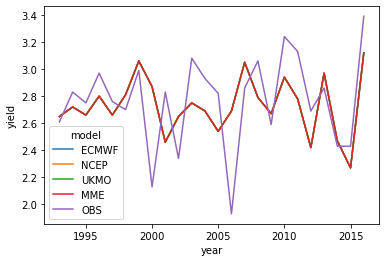

In [397]:
sns.lineplot(data=results.loc[results["init_month"] == 11], x="year", y="yield", hue="model")

<AxesSubplot:xlabel='year', ylabel='yield'>

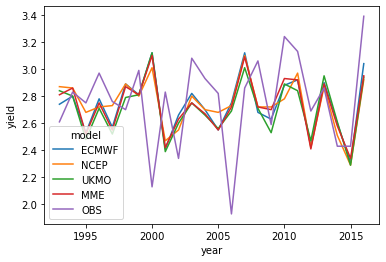

In [398]:
sns.lineplot(data=results.loc[results["init_month"] == 9], x="year", y="yield", hue="model")